In [1]:
import os
os.chdir('/Users/anthony/git-projects/midas')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core.strategies.research import DataProcessing, TimeseriesTests
from core.base.data import Direction, TradeInstruction
from core.strategies import BaseStrategy
from textwrap import dedent
import pandas as pd
from typing import Tuple, List, Dict, Any


In [2]:
## Step 1 : Retrieve and prepare data
start_date = "2018-05-18"
end_date = "2023-01-19"
symbols = ["HE.n.0", "ZC.n.0"]#, "HE.n.0"]

data_processing = DataProcessing()
data = data_processing.get_data(symbols, start_date,end_date)


There are missing values in the DataFrame:
symbol                     HE.n.0  ZC.n.0
timestamp                                
2018-08-05 00:00:00+00:00     NaN  384.25


In [3]:
## Step 2 : Data preparation
data = data.ffill()
data_processing.check_missing(data)
# log_data = np.log(data)


No missing values in the DataFrame.


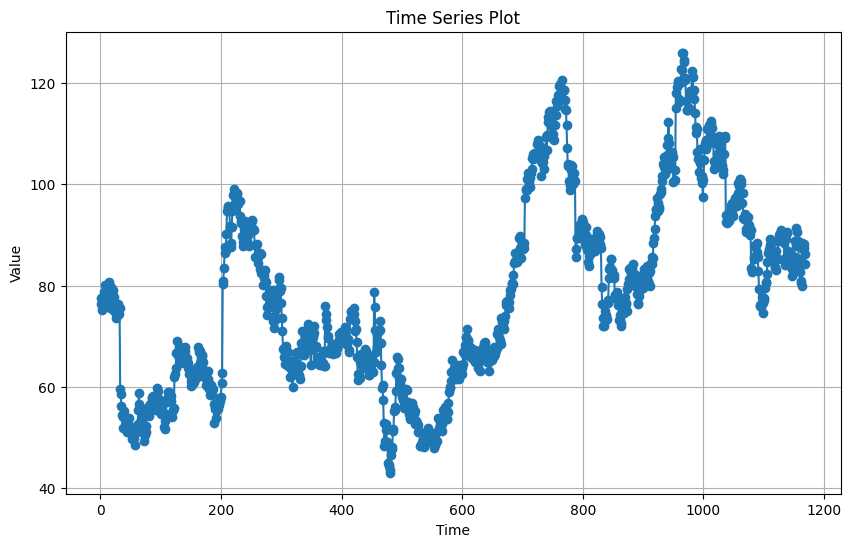

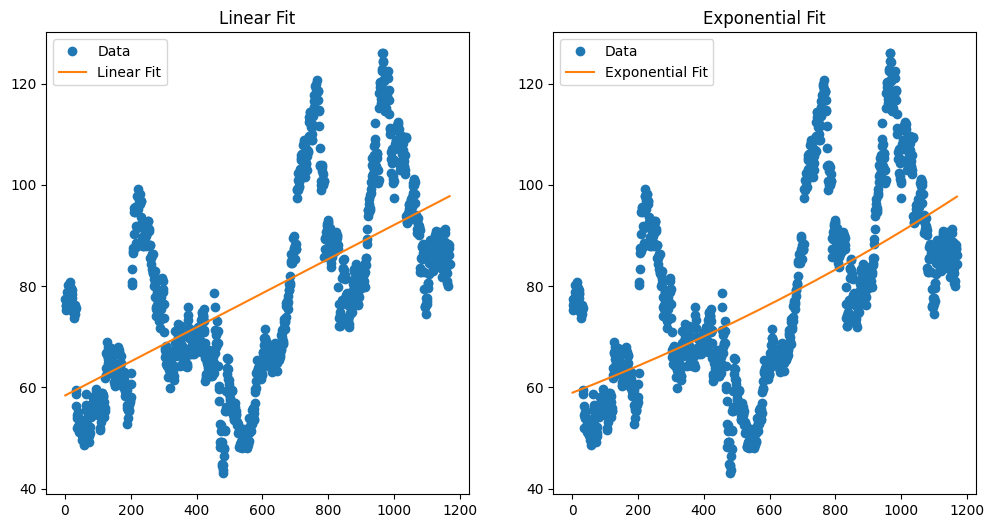

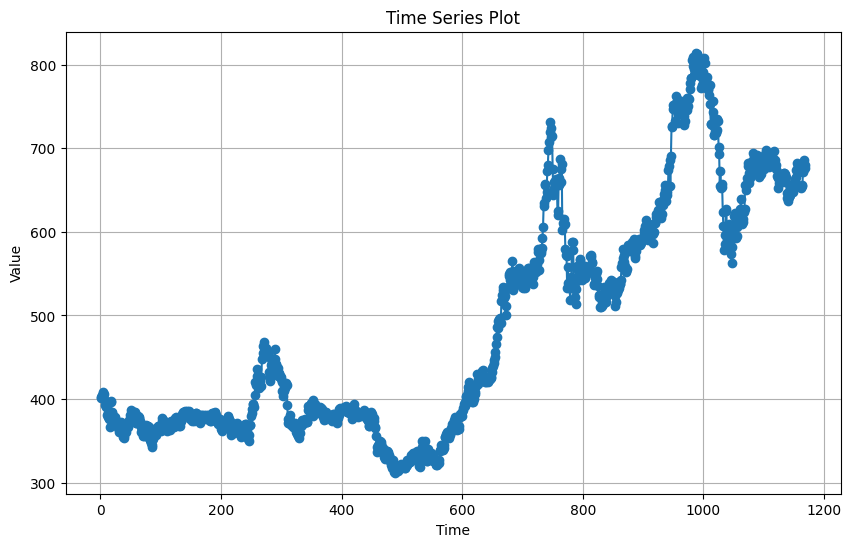

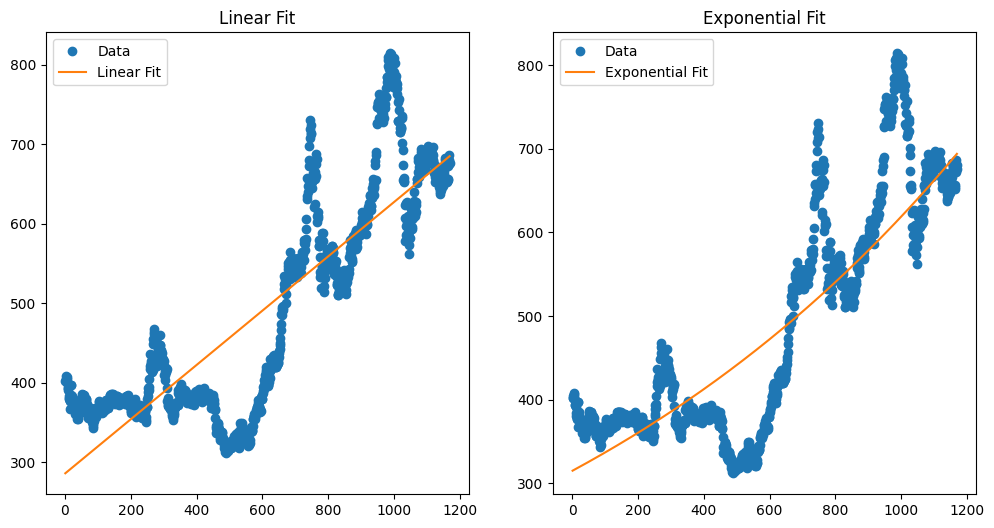


                   Ticker  Breusch-Pagan Test Statistic   p-value Heteroscedasticity
0  HE.n.0_linear_residual                     21.980127  0.000003            Present
1     HE.n.0_exp_residual                      0.005446  0.941172             Absent
2  ZC.n.0_linear_residual                    300.178396  0.000000            Present
3     ZC.n.0_exp_residual                      1.885005  0.169766             Absent
** IF p-value < 0.05, then REJECT the Null Hypothesis of homoscedasticity (constant variance) in favor of heteroscedasticity (varying variance).



In [4]:
## Step 3 : Test for exponential nature (determine if log prices will be used)
time_array = range(1, len(data) + 1)
bp_results = {}

for column in data.columns:
    value_array = data[column].values
    TimeseriesTests.line_plot(x=time_array, y=value_array)

    residuals_linear, residuals_exp = data_processing.fit_and_compare(time_array, value_array)

    bp_results[f"{column}_linear_residual"] = TimeseriesTests.breusch_pagan(np.array(residuals_linear), np.array(time_array))
    constant_to_add = abs(residuals_exp.min()) + 1

    # Adjust residuals and apply log transformation
    adjusted_residuals_exp = np.log(np.abs(residuals_exp) + constant_to_add)

    # Perform Breusch-Pagan test on adjusted residuals
    bp_results[f"{column}_exp_residual"] = TimeseriesTests.breusch_pagan(np.array(time_array), np.array(adjusted_residuals_exp))


TimeseriesTests.display_breusch_pagan_results(bp_results)



In [5]:
## Step 4 : Check stationarity
adf_results = {}
kpss_results = {}
pp_results = {}


for column in data.columns:
    series = data[column]
    adf_results[column] = TimeseriesTests.adf_test(series, trend='ct')
    pp_results[column] = TimeseriesTests.phillips_perron_test(series, trend='ct')
    # kpss_results[column] = TimeseriesTests.kpss_test(series, trend='ct')

TimeseriesTests.display_adf_results(adf_results)
TimeseriesTests.display_pp_results(pp_results)
# TimeseriesTests.display_kpss_results(kpss_results)



   Ticker  ADF Statistic   p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%)    Stationarity
0  HE.n.0      -2.664168  0.251259            -3.966549            -3.414259             -3.129268  Non-Stationary
1  ZC.n.0      -2.942952  0.148735            -3.966698            -3.414331             -3.129311  Non-Stationary
** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).


   Ticker  PP Statistic   p-value  Critical Value (1%%)  Critical Value (5%%)  Critical Value (10%%)    Stationarity
0  HE.n.0     -2.756582  0.213348             -3.966542             -3.414256              -3.129267  Non-Stationary
1  ZC.n.0     -2.532524  0.311897             -3.966542             -3.414256              -3.129267  Non-Stationary
** IF p-value < 0.05, then REJECT the Null Hypothesis of a unit root (non-stationary time series).



In [6]:
## Step 5 : Check stationarity at first difference
adf_results_diff = {}
kpss_results_diff = {}
pp_results_diff = {}

for column in data.columns:
    series = data[column].diff(1)
    series.dropna(inplace=True)
    adf_results_diff[f"{column}_diff"] = TimeseriesTests.adf_test(series)
    pp_results_diff[f"{column}_diff"] = TimeseriesTests.phillips_perron_test(series, trend='ct')
    # kpss_results_diff[f"{column}_diff"] = TimeseriesTests.kpss_test(series)

TimeseriesTests.display_adf_results(adf_results_diff)
TimeseriesTests.display_pp_results(pp_results_diff)
# TimeseriesTests.display_kpss_results(kpss_results_diff)


        Ticker  ADF Statistic   p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
0  HE.n.0_diff     -32.672131  0.000000            -3.435966            -2.864020             -2.568090   Stationary
1  ZC.n.0_diff      -5.605242  0.000001            -3.436074            -2.864068             -2.568116   Stationary
** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).


        Ticker  PP Statistic  p-value  Critical Value (1%%)  Critical Value (5%%)  Critical Value (10%%) Stationarity
0  HE.n.0_diff    -32.639404      0.0             -3.966549             -3.414259              -3.129268   Stationary
1  ZC.n.0_diff    -35.114203      0.0             -3.966549             -3.414259              -3.129268   Stationary
** IF p-value < 0.05, then REJECT the Null Hypothesis of a unit root (non-stationary time series).



In [7]:
## Step 6 : Check seasonality
seasonal_adf_results = {}

for column in data.columns:
    series = data[column]
    seasonal_adf_results[f"{column}_seasonality"] = TimeseriesTests.seasonal_adf_test(series)

TimeseriesTests.display_adf_results(seasonal_adf_results)


               Ticker  ADF Statistic  p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
0  HE.n.0_seasonality     -12.007404      0.0            -3.436114            -2.864085             -2.568125   Stationary
1  ZC.n.0_seasonality     -10.134599      0.0            -3.436130            -2.864092             -2.568129   Stationary
** IF p-value < 0.05 and/or statistic < statistic @ confidence interval, then REJECT the Null that the time series posses a unit root (non-stationary).



In [8]:
## Step 7 : Check granger causality (Use differenced data as it needs to be stationary)
data_diff = data.diff(1).dropna()
granger_results = TimeseriesTests.granger_causality(data_diff, max_lag=4)
TimeseriesTests.display_granger_results(granger_results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1122  , p=0.7377  , df_denom=1164, df_num=1
ssr based chi2 test:   chi2=0.1125  , p=0.7373  , df=1
likelihood ratio test: chi2=0.1125  , p=0.7373  , df=1
parameter F test:         F=0.1122  , p=0.7377  , df_denom=1164, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1005  , p=0.9044  , df_denom=1161, df_num=2
ssr based chi2 test:   chi2=0.2019  , p=0.9040  , df=2
likelihood ratio test: chi2=0.2019  , p=0.9040  , df=2
parameter F test:         F=0.1005  , p=0.9044  , df_denom=1161, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2130  , p=0.8874  , df_denom=1158, df_num=3
ssr based chi2 test:   chi2=0.6429  , p=0.8866  , df=3
likelihood ratio test: chi2=0.6427  , p=0.8866  , df=3
parameter F test:         F=0.2130  , p=0.8874  , df_denom=1158, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5011  , p=0.

In [9]:

# class CointegrationStrategy(BaseStrategy):
#     def __init__(self):
#         self.current_position = 0 # 1 = spread undervalued, -1 spread = overvalued
#         self.trade_id = 0
#         self.historical_data = None
#         self.historical_spread = []
#         self.historical_zscore = []
#         self.current_zscore = None
#         self.cointegration_vector = None
#         self.hedge_ratio = {}
    
#     def historic_spread(self, train_data:pd.DataFrame):
#         # Create the initial spread using the training data
#         new_spread = train_data.dot(self.cointegration_vector)
#         self.historical_spread = new_spread.tolist()

#     def update_spread(self, new_data: pd.DataFrame):
#         """
#         Update the spread with new test data.
#         """
#         new_spread_value = new_data.dot(self.cointegration_vector)
        
#         self.historical_spread.append(new_spread_value)
#         # self.test_spread.append(new_spread_value.item())  

#     def historic_zscore(self, lookback_period=None):
#         """
#         Calculate the z-scores for the historical spread data.
        
#         Parameters:
#             lookback_period (int, optional): The number of recent data points to consider for each z-score.
#                                              If None, use all available data up to each point.
#         """
#         historic_zscores = []

#         for end_index in range(1, len(self.historical_spread) + 1):
#             if lookback_period:
#                 start_index = max(0, end_index - lookback_period)
#                 spread_lookback = self.historical_spread[start_index:end_index]
#             else:
#                 spread_lookback = self.historical_spread[:end_index]

#             if len(spread_lookback) < 2:
#                 z_score = 0
#             else:
#                 mean = np.mean(spread_lookback)
#                 std = np.std(spread_lookback)
#                 z_score = (spread_lookback[-1] - mean) / std if std != 0 else 0

#             historic_zscores.append(z_score)

#         self.historical_zscore = historic_zscores

#     def update_zscore(self, lookback_period=None):
#         """
#         Update the z-score with new test data.
        
#         Parameters:
#             lookback_period (int, optional): The number of recent data points to consider for calculating the z-score.
#                                              If None, use all available data.
#         """
#         spread_lookback = self.historical_spread[-lookback_period:] if lookback_period else self.historical_spread

#         if len(spread_lookback) == 0:
#             self.current_zscore = 0
#         else:
#             self.current_zscore = (spread_lookback[-1] - np.mean(spread_lookback)) / np.std(spread_lookback)

#         # Append the current z-score to the history
#         self.historical_zscore.append(self.current_zscore)

#     def prepare(self,train_data:pd.DataFrame):
#         """
#         Prepare the strategy with training data before starting the backtest.

#         Parameters:
#             train_data (pd.DataFrame): DataFrame containing the training data.
#         """
#         self.historical_data=train_data

#         # Run cointegration test for cointegration vector
#         self.cointegration(train_data)

#         # Create the initial spread using the training data
#         self.historic_spread(train_data)

#         # Set current and historical z_score
#         self.historic_zscore()

#         # Calculate and set the initial hedge ratios
#         symbols = train_data.columns.tolist()
#         self._create_hedge_ratio(symbols, self.cointegration_vector)
    
#     def cointegration(self,train_data:pd.DataFrame):
#         # Step 8: Determine Lag Length
#         lag = TimeseriesTests.select_lag_length(data=train_data)
#         print(f"\nIdeal Lag : {lag}")

#         # Step 9: Check Cointegrations
#         johansen_results, num_cointegrations = TimeseriesTests.johansen_test(data=train_data, k_ar_diff=lag-1)
#         TimeseriesTests.display_johansen_results(johansen_results, num_cointegrations)

#         # Step 10 : Create fitted values(spread) based on long-term equilibrium relationship (V = SUM(aAt + bBt + cCt ...) for i = 0 -> i = n)
#         self.cointegration_vector = johansen_results['Cointegrating Vector'][0]

#     def reset(self):
#         """
#         Resets the strategy's state for a new test phase while preserving the training data spread.
#         """
#         self.current_position = 0
#         self.trade_id = 0
#         self.current_zscore = None

#     def data_validation(self):
#         # Test Stationarity in Spread
#         adf_spread_results = TimeseriesTests.adf_test(self.historical_spread)
#         pp_spread_results = TimeseriesTests.phillips_perron_test(self.historical_spread)

#         # Display Stationarity Test Results
#         TimeseriesTests.display_adf_results({'spread': adf_spread_results})
#         TimeseriesTests.display_pp_results({'spread': pp_spread_results})

#         # Test historical nature of spread w/ Hurst Exponent
#         hurst_exponent_result = TimeseriesTests.hurst_exponent(self.historical_spread)
#         print(f"\nHurst Exponent : {hurst_exponent_result}")

#         # Test historical half-life (expected time to mean revert)
#         spread_series = pd.Series(self.historical_spread)
#         spread_lagged = DataProcessing.lag_series(spread_series)
#         spread_combined = pd.DataFrame({'Original': spread_series, 'Lagged': spread_lagged}).dropna()
#         half_life, residuals = TimeseriesTests.half_life(Y = spread_combined['Original'], Y_lagged = spread_combined['Lagged'])
#         print(f"\nHalf-Life : {half_life}")

#         # Visualize Z-Score Spread
#         TimeseriesTests.plot_price_and_spread(price_data=self.historical_data, spread=pd.Series(self.historical_zscore))
    
#     def _create_hedge_ratio(self,symbols:list, cointegration_vector:np.array):
#         """
#         Create a dictionary of hedge ratios for each ticker.

#         Parameters:
#             data (pd.DataFrame): DataFrame containing the data with columns as tickers.
#             cointegration_vector (list): List representing the cointegration vector (hedge ratios).

#         Returns:
#             dict: Dictionary with tickers as keys and hedge ratios as values.
#         """
#         hedge_ratios = {}
        
#         # Ensure the length of cointegration_vector matches the number of columns in data
#         if len(cointegration_vector) != len(symbols):
#             raise ValueError("Length of cointegration vector must match the number of symbols.")

#         # Populate the dictionary with symbols and corresponding hedge ratios
#         for symbol, hedge_ratio in zip(symbols, cointegration_vector):
#             hedge_ratios[symbol] = hedge_ratio

#         self.hedge_ratio = hedge_ratios

#     def asset_allocation(self):
#         # hedge ratios pulled from the cointegration vector
#         pass

#     def entry_signal(self, z_score:float, entry_threshold:float=2.0):
#         if z_score > entry_threshold:
#             print(f"Spread overvalued: z_score : {z_score} > entry_threshold : {entry_threshold}")
#             self.current_position = -1 # Short the spread
#             return True
#         elif z_score < -entry_threshold:
#             print(f"Spread undervalued: z_score : {z_score} < entry_threshold : -{entry_threshold}")
#             self.current_position = 1 # Long the spread
#             return True

#     def exit_signal(self,z_score:float, exit_threshold:float=0.5):
#         if (self.current_position == 1 and z_score >= exit_threshold):
#             print(f"Exiting a long, spread no longer undervalued : z_score : {z_score} >= entry_threshold : {exit_threshold}")
#             self.current_position = 0 # Exit position 

#         elif (self.current_position == -1 and z_score <= -exit_threshold):
#             print(f"Exiting a short, spread no longer overvalued : z_score : {z_score} <= entry_threshold : {exit_threshold}")
#             self.current_position = 0 # Exit position

#     def handle_market_data(self, data, entry_threshold: float, exit_threshold: float):
#         self.update_spread(data)
#         self.update_zscore()

#         if self.current_position == 0 and self.entry_signal(self.current_zscore, entry_threshold):
#             self.trade_id += 1
#             return self.generate_trade_instructions(self.current_position)
        
#         elif self.current_position != 0 and self.exit_signal(self.current_zscore, exit_threshold):
#             return self.generate_trade_instructions(self.current_position)

#         return None
    
#     def generate_trade_instructions(self, direction):
#         trade_instructions = []
#         leg_id = 1
        
#         for ticker, hedge_ratio in self.hedge_ratio.items():
#             # Determine the direction for each ticker based on the overall direction and hedge ratio
#             if (direction == 1 and hedge_ratio > 0) or (direction == -1 and hedge_ratio < 0):
#                 trade_direction = Direction.LONG 
#                 hedge_ratio = abs(hedge_ratio)
#             else:
#                 trade_direction = Direction.SHORT
#                 hedge_ratio = -1 * abs(hedge_ratio)

#             trade_instructions.append(TradeInstruction(ticker, trade_direction, self.trade_id, leg_id, hedge_ratio))
#             leg_id += 1
            
#         return trade_instructions 
    


In [54]:
class CointegrationStrategy(BaseStrategy):
    def __init__(self):
        # super().__init__()
        self.current_position = 0  # 0: no position, 1: long, -1: short
        self.trade_id = 0
        self.historical_data = None
        self.historical_spread = []
        self.historical_zscore = []
        self.current_zscore = None
        self.cointegration_vector = None
        self.hedge_ratio = {}

    def reset(self):
        """
        Resets the strategy's state for a new test phase while preserving the training data spread.
        """
        self.current_position = 0
        self.trade_id = 0
        self.current_zscore = None

    def prepare(self, train_data: pd.DataFrame):
        self.historical_data = train_data
        self.cointegration(train_data)
        self.historic_spread(train_data)
        self.historic_zscore()
        symbols = train_data.columns.tolist()
        self.asset_allocation(symbols, self.cointegration_vector)

    def cointegration(self,train_data:pd.DataFrame):
        # Determine Lag Length
        lag = TimeseriesTests.select_lag_length(data=train_data)
        print(f"\nIdeal Lag : {lag}")

        # Check Cointegration Relationship
        johansen_results, num_cointegrations = TimeseriesTests.johansen_test(data=train_data, k_ar_diff=lag-1)
        TimeseriesTests.display_johansen_results(johansen_results, num_cointegrations)

        self.cointegration_vector = johansen_results['Cointegrating Vector'][0]
        print(self.cointegration_vector)

    def historic_spread(self, train_data: pd.DataFrame):
        new_spread = train_data.dot(self.cointegration_vector)
        self.historical_spread = new_spread.tolist()

    def update_spread(self, new_data: pd.DataFrame):
        self.historical_spread.append(new_data.dot(self.cointegration_vector))
        # self.test_spread.append(new_spread_value.item())  

    def historic_zscore(self, lookback_period=None):
        self.historical_zscore = []

        for end_index in range(1, len(self.historical_spread) + 1):
            if lookback_period:
                start_index = max(0, end_index - lookback_period)
                spread_lookback = self.historical_spread[start_index:end_index]
            else:
                spread_lookback = self.historical_spread[:end_index]

            z_score = self.calculate_single_zscore(spread_lookback)
            self.historical_zscore.append(z_score)

    def calculate_single_zscore(self, spread_lookback):
        if len(spread_lookback) < 2:
            return 0
        mean = np.mean(spread_lookback)
        std = np.std(spread_lookback)
        return (spread_lookback[-1] - mean) / std if std != 0 else 0
    
    def update_zscore(self,lookback_period=None):
        # Determine the lookback range for the z-score calculation
        spread_lookback = self.historical_spread[-lookback_period:] if lookback_period else self.historical_spread

        # Calculate and append the new z-score
        self.current_zscore = self.calculate_single_zscore(spread_lookback)
        self.historical_zscore.append(self.current_zscore)

    def data_validation(self):
        # Test Stationarity in Spread
        adf_spread_results = TimeseriesTests.adf_test(self.historical_spread)
        pp_spread_results = TimeseriesTests.phillips_perron_test(self.historical_spread)

        # Display Stationarity Test Results
        TimeseriesTests.display_adf_results({'spread': adf_spread_results})
        TimeseriesTests.display_pp_results({'spread': pp_spread_results})

        # Test historical nature of spread w/ Hurst Exponent
        hurst_exponent_result = TimeseriesTests.hurst_exponent(self.historical_spread)
        print(f"\nHurst Exponent : {hurst_exponent_result}")

        # Test historical half-life (expected time to mean revert)
        spread_series = pd.Series(self.historical_spread)
        spread_lagged = DataProcessing.lag_series(spread_series)
        spread_combined = pd.DataFrame({'Original': spread_series, 'Lagged': spread_lagged}).dropna()
        half_life, residuals = TimeseriesTests.half_life(Y = spread_combined['Original'], Y_lagged = spread_combined['Lagged'])
        print(f"\nHalf-Life : {half_life}")

        # Visualize Z-Score Spread
        TimeseriesTests.plot_price_and_spread(price_data=self.historical_data, spread=pd.Series(self.historical_zscore))
    
    def asset_allocation(self,symbols:list, cointegration_vector:np.array):
        """
        Create a dictionary of hedge ratios for each ticker.

        Parameters:
            data (pd.DataFrame): DataFrame containing the data with columns as tickers.
            cointegration_vector (list): List representing the cointegration vector (hedge ratios).

        Returns:
            dict: Dictionary with tickers as keys and hedge ratios as values.
        """

        normalized_cointegration_vector = cointegration_vector / np.sum(np.abs(cointegration_vector))

        # Ensure the length of cointegration_vector matches the number of symbols
        if len(normalized_cointegration_vector) != len(symbols):
            raise ValueError("Length of normalized cointegration vector must match the number of symbols.")

            hedge_ratios = {}
        
        # # Ensure the length of cointegration_vector matches the number of columns in data
        # if len(cointegration_vector) != len(symbols):
        #     raise ValueError("Length of cointegration vector must match the number of symbols.")

        # Populate the dictionary with symbols and corresponding hedge ratios
        # Create a dictionary of symbols and corresponding normalized hedge ratios
        hedge_ratios = {symbol: ratio for symbol, ratio in zip(symbols, normalized_cointegration_vector)}

        self.hedge_ratio = hedge_ratios

    def entry_signal(self, z_score: float, entry_threshold: float):
        if z_score > entry_threshold or z_score < -entry_threshold:
            self.current_position = -1 if z_score > entry_threshold else 1
            print(f"Entry signal z_score : {z_score} // entry_threshold : {entry_threshold} // direction : {self.current_position}")
            return True
        return False

    def exit_signal(self, z_score: float, exit_threshold: float):
        if (self.current_position == 1 and z_score >= exit_threshold) or \
           (self.current_position == -1 and z_score <= -exit_threshold):
            self.current_position = 0
            print(f"Exit signal z_score : {z_score} // entry_threshold : {exit_threshold} // direction : {self.current_position}")
            return True
        return False
    
    def generate_trade_instructions(self, direction):
        trade_instructions = []
        leg_id = 1
        
        for ticker, hedge_ratio in self.hedge_ratio.items():
            # Determine the direction for each ticker based on the overall direction and hedge ratio
            if (direction == 1 and hedge_ratio > 0) or (direction == -1 and hedge_ratio < 0):
                trade_direction = Direction.LONG 
                hedge_ratio = abs(hedge_ratio)
            else:
                trade_direction = Direction.SHORT
                hedge_ratio = -1 * abs(hedge_ratio)

            trade_instructions.append(TradeInstruction(ticker, trade_direction, self.trade_id, leg_id, hedge_ratio))
            leg_id += 1
            
        return trade_instructions 
    
    def handle_market_data(self, data, entry_threshold: float, exit_threshold: float):
        self.update_spread(data)
        self.update_zscore()

        if self.entry_signal(self.current_zscore, entry_threshold):
            self.trade_id += 1
            return self.generate_trade_instructions(self.current_position)
        elif self.exit_signal(self.current_zscore, exit_threshold):
            return self.generate_trade_instructions(0)  # Reset position to 0

        return None
    








In [59]:
class BacktestPerformance:
    @staticmethod
    def sharpe_ratio(equity_curve: list, risk_free_rate: float = 0.04):
        daily_returns =  BacktestPerformance.daily_return(equity_curve)
        excess_returns = [r - risk_free_rate for r in daily_returns]

        if np.std(excess_returns) != 0:
            return np.mean(excess_returns) / np.std(excess_returns)
        else: 
            return 0
        
    @staticmethod
    def daily_return(equity_curve: list):
        df = pd.DataFrame({'equity_value': equity_curve})
        df['daily_return'] = df['equity_value'].pct_change()  # Decimal format
        df['daily_return'].fillna(0, inplace=True)  # Replace NaN with 0 for the first element
        return df['daily_return'].tolist()

    @staticmethod
    def cumulative_return(equity_curve: list):
        df = pd.DataFrame({'equity_value': equity_curve})
        df['daily_return'] = df['equity_value'].pct_change()
        df['cumulative_total_return'] = (1 + df['daily_return']).cumprod() - 1
        df['cumulative_total_return'].fillna(0, inplace=True)
        # Convert to percentage
        df['cumulative_total_return'] *= 100
        return df['cumulative_total_return'].tolist()

    @staticmethod
    def drawdown(equity_curve:list):
        df = pd.DataFrame({'equity_value': equity_curve})
        rolling_max = df['equity_value'].cummax()
        df['percent_drawdown'] = round((df['equity_value'] - rolling_max ) / rolling_max * 100, 4)
        df['percent_drawdown'].fillna(0, inplace=True)  # Replace NaN with 0
        return df['percent_drawdown'].tolist()
    
    @staticmethod
    def plot_data_with_signals(data, signals):
        plt.figure(figsize=(15, 7))

        for symbol in data.columns:
            plt.plot(data.index, data[symbol], label=symbol)

        for signal in signals:
            color = 'green' if signal['direction'] == 1 else 'red'
            plt.scatter(signal['timestamp'], signal['price'], color=color, marker='o' if signal['direction'] == 1 else 'x')

        plt.legend()
        plt.title("Price Data with Trade Signals")
        plt.xlabel("Timestamp")
        plt.ylabel("Price")
        plt.show()

    @staticmethod
    def plot_price_and_spread(price_data:pd.DataFrame, spread:list, signals: list):
        """
        Plot multiple ticker data on the left y-axis and spread with mean and standard deviations on the right y-axis.
        
        Parameters:
            price_data (pd.DataFrame): DataFrame containing the data with timestamps as index and multiple ticker columns.
            spread (pd.Series): Series containing the spread data.
        """
        # Extract data from the DataFrame
        timestamps = price_data.index
        spread = pd.Series(spread, index=timestamps) 

        # Create a figure and primary axis for price data (left y-axis)
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot each ticker on the left y-axis
        colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']  # Extend this list as needed
        for i, ticker in enumerate(price_data.columns):
            color = colors[i % len(colors)]  # Cycle through colors
            ax1.plot(timestamps, price_data[ticker], label=ticker, color=color, linewidth=2)

        ax1.set_yscale('linear')
        ax1.set_ylabel('Price')
        ax1.legend(loc='upper left')

        # Calculate mean and standard deviations for spread
        spread_mean = spread.rolling(window=20).mean()  # Adjust the window size as needed
        spread_std_1 = spread.rolling(window=20).std()  # 1 standard deviation
        spread_std_2 = 2 * spread.rolling(window=20).std()  # 2 standard deviations

        # Create a secondary axis for the spread with mean and standard deviations (right y-axis)
        ax2 = ax1.twinx()

        # Plot Spread on the right y-axis
        ax2.plot(timestamps, spread, label='Spread', color='purple', linewidth=2)
        ax2.plot(timestamps, spread_mean, label='Mean', color='orange', linestyle='--')
        ax2.fill_between(timestamps, spread_mean - spread_std_1, spread_mean + spread_std_1, color='gray', alpha=0.2, label='1 Std Dev')
        ax2.fill_between(timestamps, spread_mean - spread_std_2, spread_mean + spread_std_2, color='gray', alpha=0.4, label='2 Std Dev')
        ax2.set_yscale('linear')
        ax2.set_ylabel('Spread and Statistics')
        ax2.legend(loc='upper right')

        # Plot Signals
        for signal in signals:
            if signal['direction'] == 'LONG':  # Long signal
                ax1.scatter(signal['timestamp'], price_data.loc[signal['timestamp'], signal['symbol']], color='lime', marker='^', s=100)
            elif signal['direction'] == 'SHORT':  # Short signal
                ax1.scatter(signal['timestamp'], price_data.loc[signal['timestamp'], signal['symbol']], color='red', marker='v', s=100)

        # Add grid lines
        ax1.grid(True)

        # Format x-axis labels for better readability
        plt.xticks(rotation=45)
        plt.xlabel('Timestamp')

        # Title
        plt.title('Price Data, Spread, and Statistics Over Time')

        # Show the plot
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_equity_curve(equity_curve):
        plt.figure(figsize=(12, 6))
        plt.plot(equity_curve, label='Equity Curve')
        plt.title(f"Equity Curve")
        plt.xlabel('Time')
        plt.ylabel('Equity')
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.legend()
        plt.show()
    
    @staticmethod
    def plot_drawdown_curve(drawdown):
        plt.figure(figsize=(12, 6))
        plt.plot(drawdown, label='Drawdown Curve')
        plt.title(f"Drawdown Curve")
        plt.xlabel('Time')
        plt.ylabel('Drawdown (%)')
        plt.axhline(y=0, color='red', linestyle='--')
        plt.legend()
        plt.show()
    
    @staticmethod
    def plot_return_curve(drawdown):
        plt.figure(figsize=(12, 6))
        plt.plot(drawdown, label='Return Curve')
        plt.title(f"Return Curve")
        plt.xlabel('Time')
        plt.ylabel('Return (%)')
        plt.axhline(y=0, color='blue', linestyle='--')
        plt.legend()
        plt.show()
    
    @staticmethod
    def calculate_metrics(equity_curve):
        cum_return_curve = BacktestPerformance.cumulative_return(equity_curve)
        drawdown_curve = BacktestPerformance.drawdown(equity_curve)

        BacktestPerformance.plot_equity_curve(equity_curve)
        BacktestPerformance.plot_return_curve(cum_return_curve)
        BacktestPerformance.plot_drawdown_curve(drawdown_curve)

        # Calculate Sharpe ratio using daily returns
        sharpe_ratio = BacktestPerformance.sharpe_ratio(equity_curve)
        max_drawdown = min(drawdown_curve)
        total_return = cum_return_curve[-1]

        return {'Total Return(%)': total_return, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown(%)': max_drawdown}

class Backtest(BacktestPerformance):
    def __init__(self, strategy: BaseStrategy, full_data: pd.DataFrame, trade_allocation: int=0.20, initial_capital: int = 10000) -> None:
        self.full_data = full_data
        self.strategy = strategy
        self.initial_capital = initial_capital
        self.trade_allocation = trade_allocation

    def print_summary(self,title: str, summary_dict: Dict[str, Any]) -> None:
        print(f"{title}:\n" + "=" * len(title))
        for key, value in summary_dict.items():
            print(f"{key}: {value}")
        print("\n")

    def split_data(self,data: pd.DataFrame, train_ratio: float = 0.8) -> Tuple[pd.DataFrame, pd.DataFrame]:
        train_size = int(len(data) * train_ratio)
        return data.iloc[:train_size], data.iloc[train_size:]

    def walk_forward_analysis(self, total_segments: int, entry_thresholds: List[float], exit_thresholds: List[float]) -> None:
        segment_size = len(self.full_data) // total_segments

        for i in range(1, total_segments + 1):
            current_window_data = self.full_data.iloc[:segment_size * i]
            train_data, test_data = self.split_data(current_window_data)
            
            segment_summary = {
                'Segment': i,
                'Initial Capital': self.initial_capital,
                'Training Data Range': f"{train_data.index[0]} to {train_data.index[-1]}",
                'Testing Data Range': f"{test_data.index[0]} to {test_data.index[-1]}"
            }
            self.print_summary("Parameter Summary", segment_summary)

            # Reset the strategy before sensitivity analysis
            self.strategy.reset()

            # Prepare the strategy with training data
            self.strategy.prepare(train_data)

            # Validate
            self.strategy.data_validation()

            performance_metrics = self.sensitivity_analysis(test_data, entry_thresholds, exit_thresholds)
            self.print_sensitivity_results(performance_metrics)
    
    def print_sensitivity_results(self, results: Dict) -> None:
        header = "Entry Threshold, Exit Threshold | Total Return(%) | Sharpe Ratio | Max Drawdown(%)"
        print(header)
        print("=" * len(header))
        for thresholds, metrics in results.items():
            row = f"{thresholds[0]}, {thresholds[1]} | {metrics['Total Return(%)']:.2f}% | {metrics['Sharpe Ratio']:.2f} | {metrics['Max Drawdown(%)']:.2f}%"
            print(row)
    
    def sensitivity_analysis(self, test_data: pd.DataFrame, entry_thresholds: List[float], exit_thresholds: List[float]) -> Dict:
        results = {}

        for entry_threshold in entry_thresholds:
            for exit_threshold in exit_thresholds:
                self.strategy.reset()  
                sensitivity_params = {
                    'Entry Threshold': entry_threshold,
                    'Exit Threshold': exit_threshold
                }
                self.print_summary("Sensitivity Analysis Parameters", sensitivity_params)

                equity_curve, signals = self.run_backtest(test_data, entry_threshold, exit_threshold)
                results[(entry_threshold, exit_threshold)] = self.calculate_metrics(equity_curve)

        return results

    def run_backtest(self, data: pd.DataFrame, entry_threshold: float, exit_threshold: float) -> Tuple[List[float], List[Dict]]:
        equity_curve = [self.initial_capital]
        signals = []
        positions = {}
        capital = self.initial_capital  # Get the last known capital

        for i, row in data.iterrows():
            trade_instructions = self.strategy.handle_market_data(row, entry_threshold, exit_threshold)

            if trade_instructions != None:
                print(capital)
                print(positions)
                capital = self.update_positions_and_signals(trade_instructions, row, positions, signals, capital)
                print(positions)
                print(capital)
                
            # Update equity curve
            current_portfolio_value = self.calculate_portfolio_value(row, positions)
            equity_curve.append(capital + current_portfolio_value)

        return equity_curve, signals
    
    def calculate_portfolio_value(self, market_data, positions):
        # Calculate the current value of all positions
        portfolio_value = 0
        for symbol, pos_info in positions.items():
            portfolio_value += (market_data[symbol] - pos_info['entry_price']) * pos_info['weight']
        return portfolio_value

    def update_positions_and_signals(self, trade_instructions, market_data, positions, signals, capital):
        timestamp = market_data.name

        for trade in trade_instructions:
            symbol = trade.contract
            direction = trade.direction
            weight = trade.allocation_percent
            current_price = market_data[symbol]
            units = ((self.trade_allocation * capital) * weight)/ current_price
            
            # Record signal
            signals.append({
                "timestamp": timestamp,
                "symbol": symbol,
                "direction": direction,
                "weight":weight,
                "price": current_price, 
                "units": units

            })

            if symbol in positions:
                position_info = positions[symbol]
                if direction == position_info['direction']:
                    current_value = position_info['entry_price'] * position_info['units'] # value of position before trade
                    added_value = current_price * units # value of trade
                    position_info['units'] += units # updated units
                    position_info['entry_price'] = (current_value + added_value) / position_info['units'] # adjust price to accoutn for new units
                    capital -= current_price * weight  # Deduct the investment from capital
                else:
                    # Calculate P&L for exiting position
                    trade_value = self.record_trade(position_info['entry_price'], current_price, position_info['units'])
                    capital += trade_value # Update capital with P&L
                    # Remove the position
                    del positions[symbol]
            else:
                # Enter new position
                positions[symbol] = {'direction': direction, 'units': units, 'entry_price': current_price, 'weight': weight}
                capital -= units * current_price # Deduct the investment from capital

        return capital

    def record_trade(self, entry_price, current_price, units):
        trade_value = (current_price - entry_price) * units
        return trade_value

Parameter Summary:
Segment: 1
Initial Capital: 10000
Training Data Range: 2018-05-18 00:00:00+00:00 to 2019-08-13 00:00:00+00:00
Testing Data Range: 2019-08-14 00:00:00+00:00 to 2019-12-05 00:00:00+00:00



Ideal Lag : 2

Number of cointerated realtionships : 0

  Hypothesis  Eigenvalue  Trace Statistic  Critical Value (Trace)  Max Eigenvalue Statistic  Critical Value (Max Eigenvalue) Decision (Trace) Decision (Max Eigenvalue)
0         H0    0.012714         4.240205                 10.4741                  3.953724                          12.3212   Fail to Reject            Fail to Reject
1         H1    0.000927         0.286481                  2.9762                  0.286481                           4.1296   Fail to Reject            Fail to Reject
** IF Trace Statistic > Critical Value AND Max Eigenvalue > Critical Value then Reject Null of at most r cointegrating relationships.(r=0 in first test)

[0.07388373 0.0044014 ]

   Ticker  ADF Statistic  p-value  Critical Value (1%)

/Users/anthony/git-projects/midas/core/strategies/research/timeseries_analysis.py:722: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model.params[-1]  # Get the AR coefficient (last parameter)


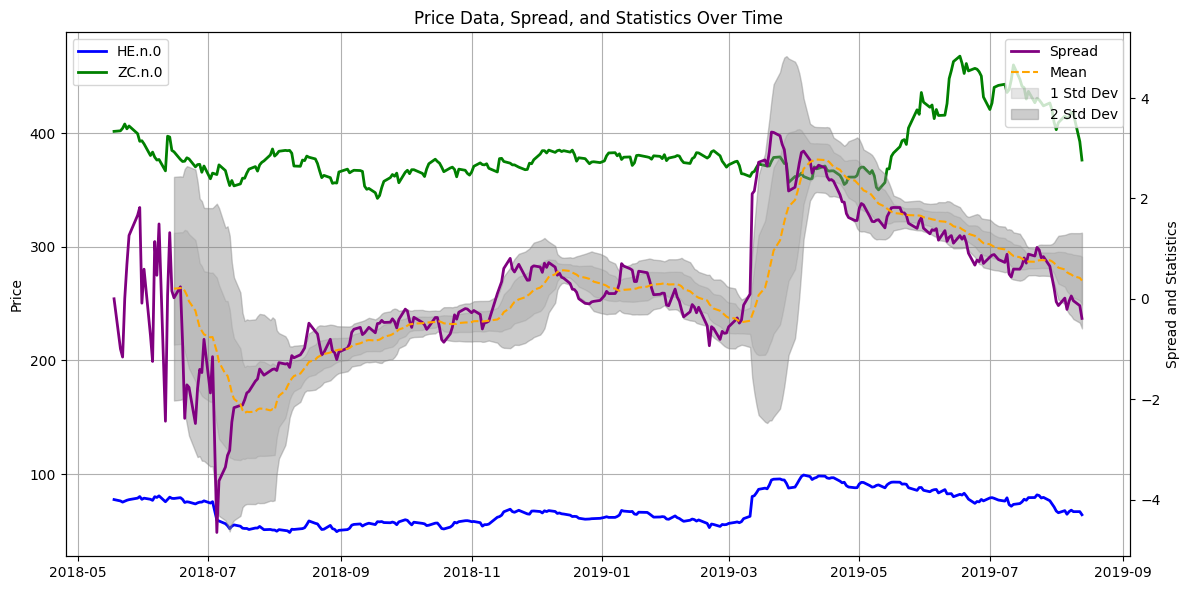

Sensitivity Analysis Parameters:
Entry Threshold: 0.5
Exit Threshold: 0.0


Entry signal z_score : -0.5187256681890522 // entry_threshold : 0.5 // direction : 1
10000
{}
{'HE.n.0': {'direction': 'LONG', 'units': 30.444428206076253, 'entry_price': 62.0, 'weight': 0.9437772743883638}, 'ZC.n.0': {'direction': 'LONG', 'units': 0.23942456411731902, 'entry_price': 381.0, 'weight': 0.05622272561163626}}
8021.224692294574
Entry signal z_score : -0.5401682447968674 // entry_threshold : 0.5 // direction : 1
8021.224692294574
{'HE.n.0': {'direction': 'LONG', 'units': 30.444428206076253, 'entry_price': 62.0, 'weight': 0.9437772743883638}, 'ZC.n.0': {'direction': 'LONG', 'units': 0.23942456411731902, 'entry_price': 381.0, 'weight': 0.05622272561163626}}
{'HE.n.0': {'direction': 'LONG', 'units': 54.75675121643488, 'entry_price': 62.12210163458057, 'weight': 0.9437772743883638}, 'ZC.n.0': {'direction': 'LONG', 'units': 0.4810821596166701, 'entry_price': 375.72563115879205, 'weight': 0.056222725611636

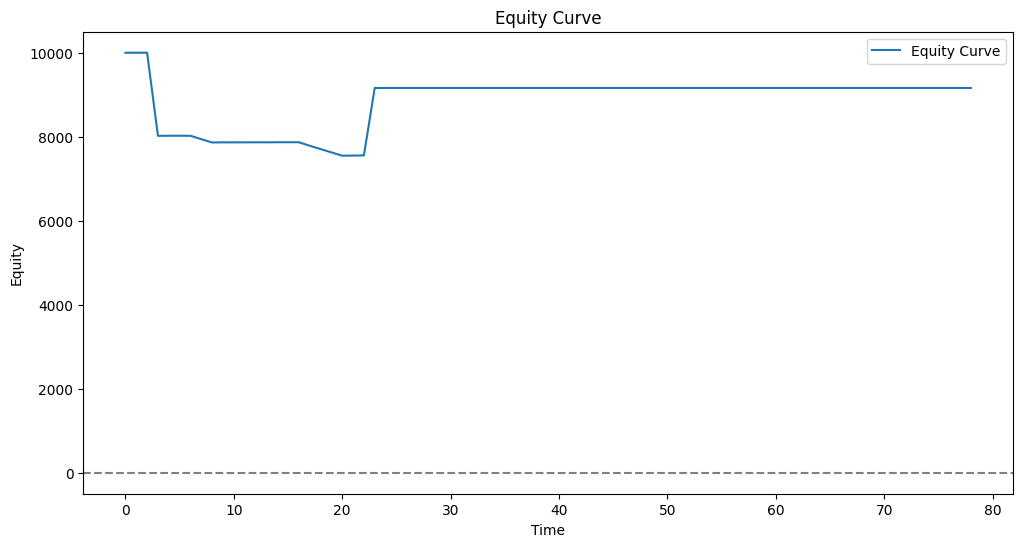

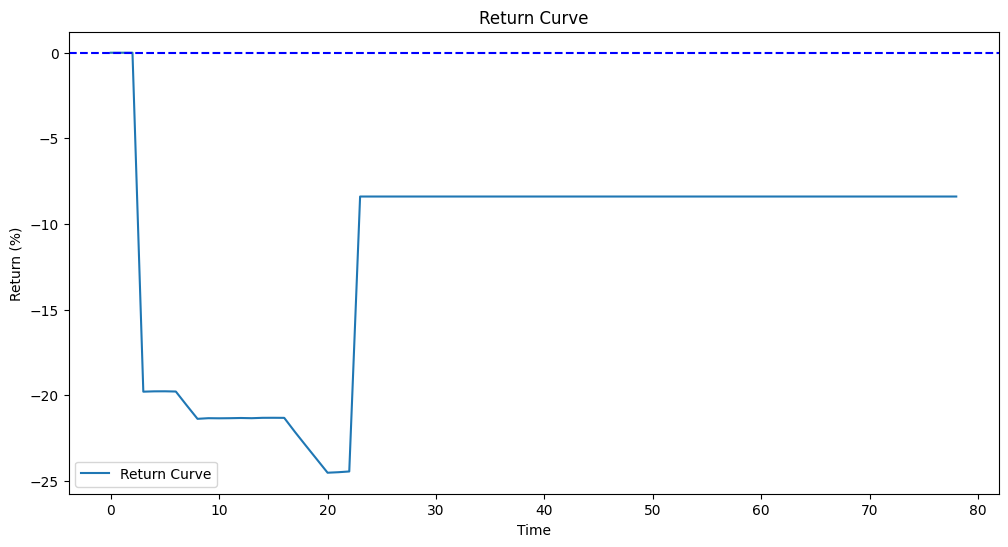

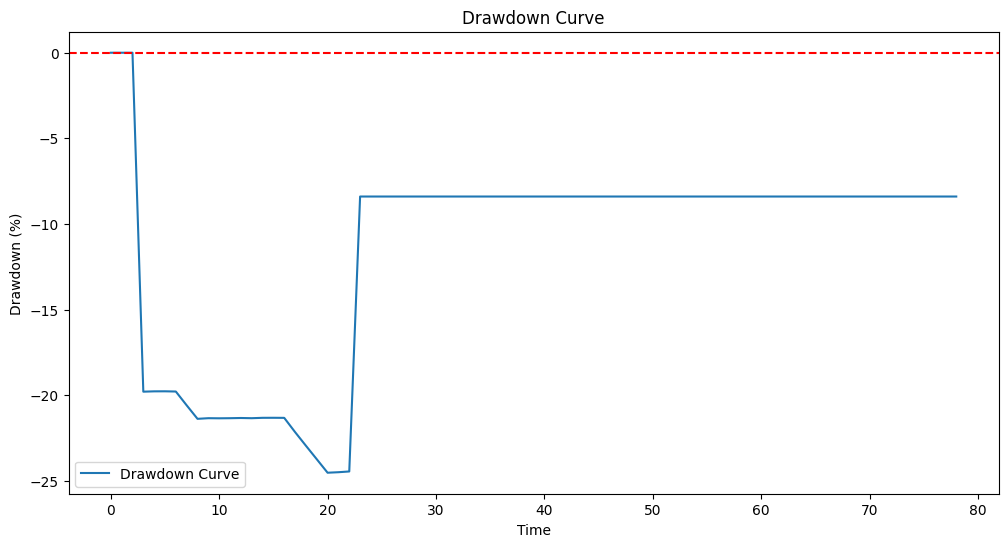

Sensitivity Analysis Parameters:
Entry Threshold: 1.0
Exit Threshold: 0.0




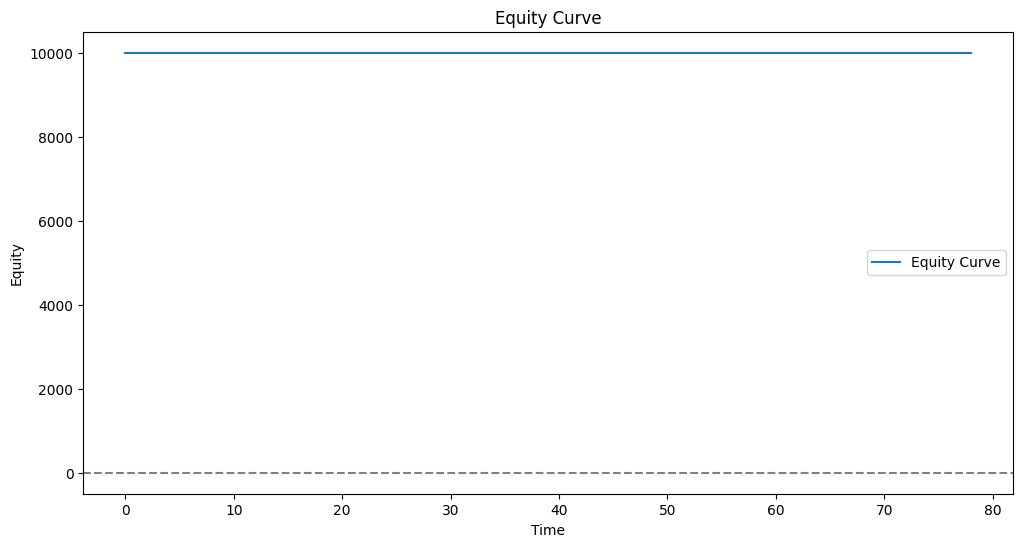

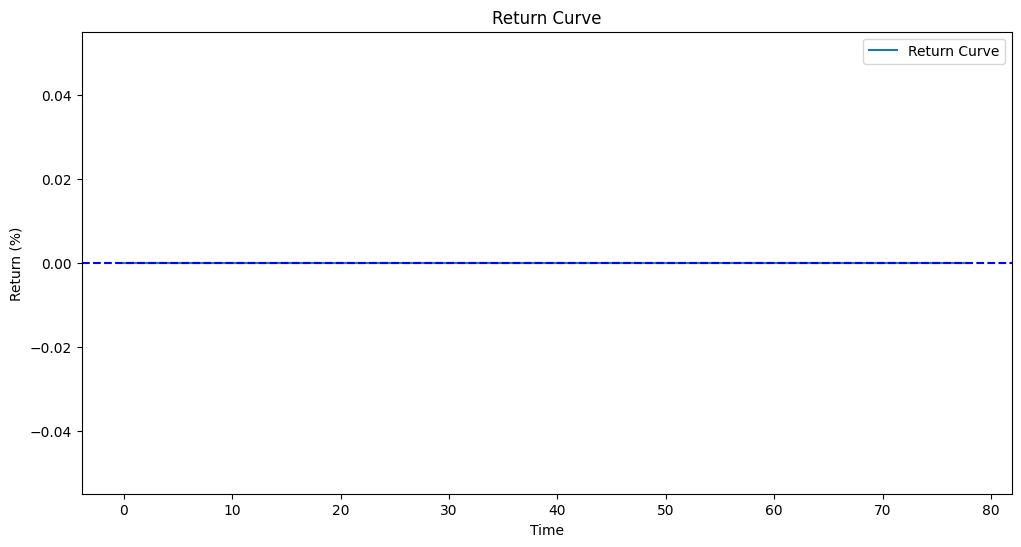

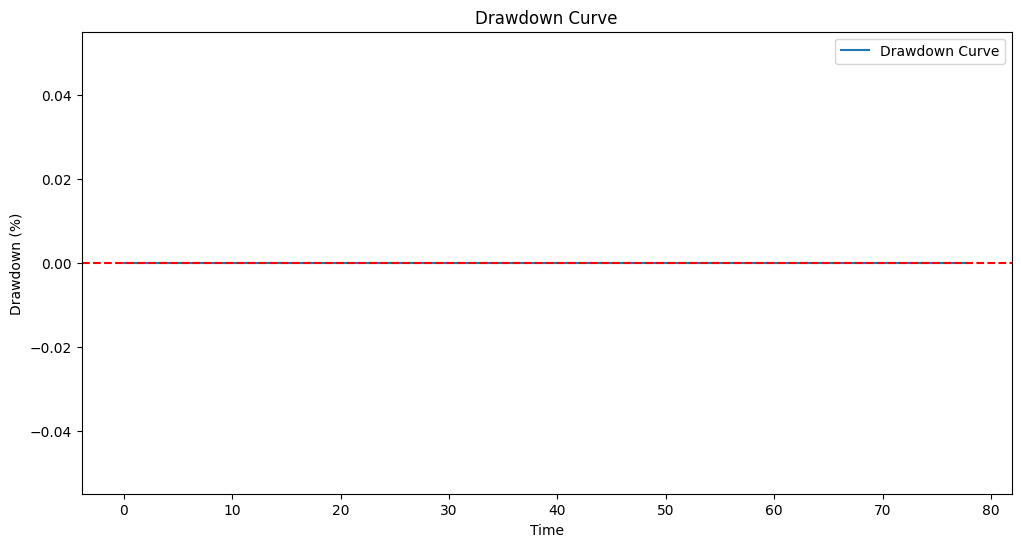

Entry Threshold, Exit Threshold | Total Return(%) | Sharpe Ratio | Max Drawdown(%)
0.5, 0.0 | -8.39% | -1.24 | -24.52%
1.0, 0.0 | 0.00% | 0.00 | 0.00%
Parameter Summary:
Segment: 2
Initial Capital: 10000
Training Data Range: 2018-05-18 00:00:00+00:00 to 2020-11-06 00:00:00+00:00
Testing Data Range: 2020-11-09 00:00:00+00:00 to 2021-06-24 00:00:00+00:00



Ideal Lag : 1

Number of cointerated realtionships : 0

  Hypothesis  Eigenvalue  Trace Statistic  Critical Value (Trace)  Max Eigenvalue Statistic  Critical Value (Max Eigenvalue) Decision (Trace) Decision (Max Eigenvalue)
0         H0    0.012021          7.54183                 10.4741                   7.51024                          12.3212   Fail to Reject            Fail to Reject
1         H1    0.000051          0.03159                  2.9762                   0.03159                           4.1296   Fail to Reject            Fail to Reject
** IF Trace Statistic > Critical Value AND Max Eigenvalue > Critical Value then Re

/Users/anthony/git-projects/midas/core/strategies/research/timeseries_analysis.py:722: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model.params[-1]  # Get the AR coefficient (last parameter)


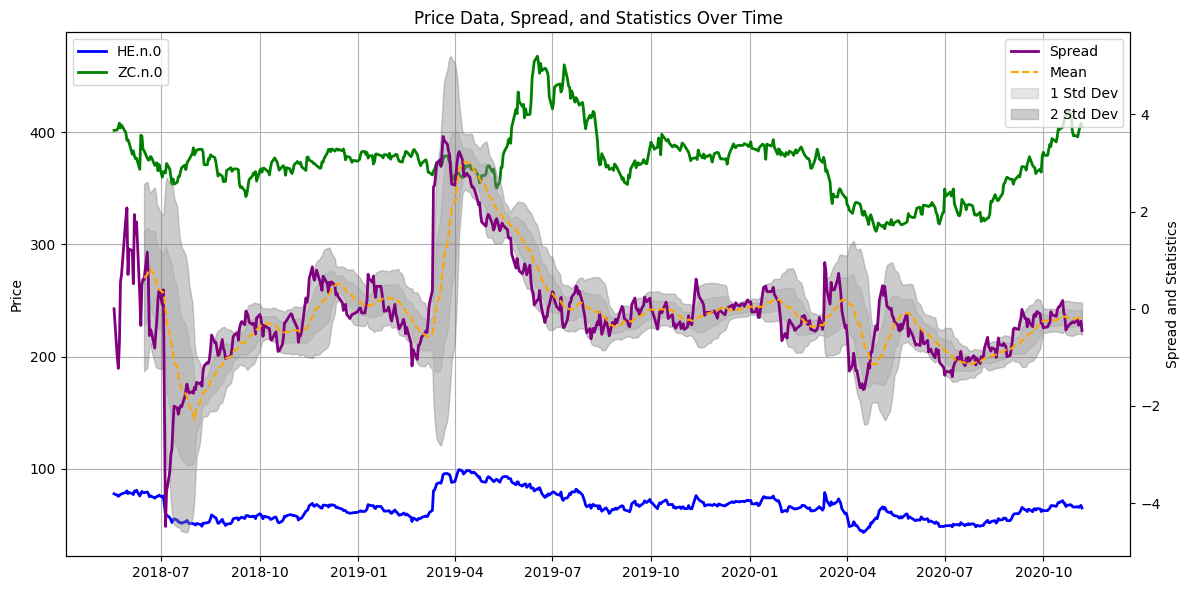

Sensitivity Analysis Parameters:
Entry Threshold: 0.5
Exit Threshold: 0.0


Entry signal z_score : -0.6770623357261943 // entry_threshold : 0.5 // direction : 1
10000
{}
{'HE.n.0': {'direction': 'LONG', 'units': 27.422162141470608, 'entry_price': 65.225, 'weight': 0.89430526283871}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.4041446576100154, 'entry_price': 429.5, 'weight': -0.10569473716128996}}
8384.96960476608
Entry signal z_score : -0.6166060850425543 // entry_threshold : 0.5 // direction : 1
8384.96960476608
{'HE.n.0': {'direction': 'LONG', 'units': 27.422162141470608, 'entry_price': 65.225, 'weight': 0.89430526283871}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.4041446576100154, 'entry_price': 429.5, 'weight': -0.10569473716128996}}
{'HE.n.0': {'direction': 'LONG', 'units': 50.67401468809052, 'entry_price': 64.89233259245272, 'weight': 0.89430526283871}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.8252692517634388, 'entry_price': 423.63169359888786, 'weight': -0.105694737161

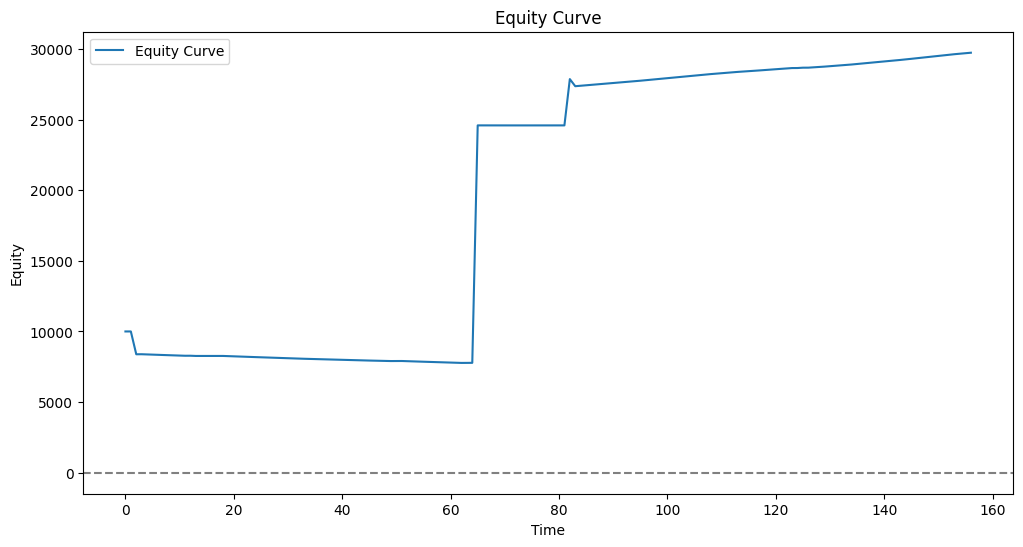

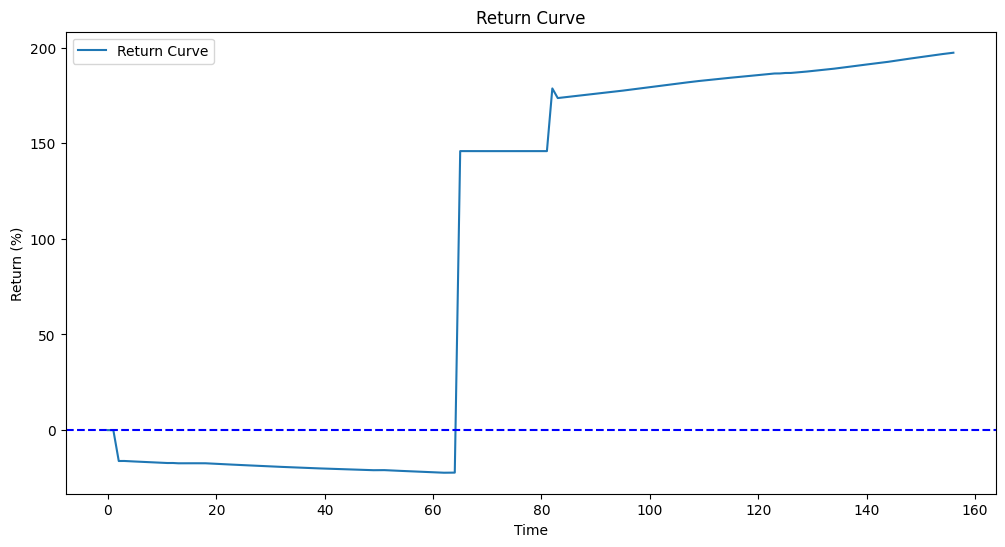

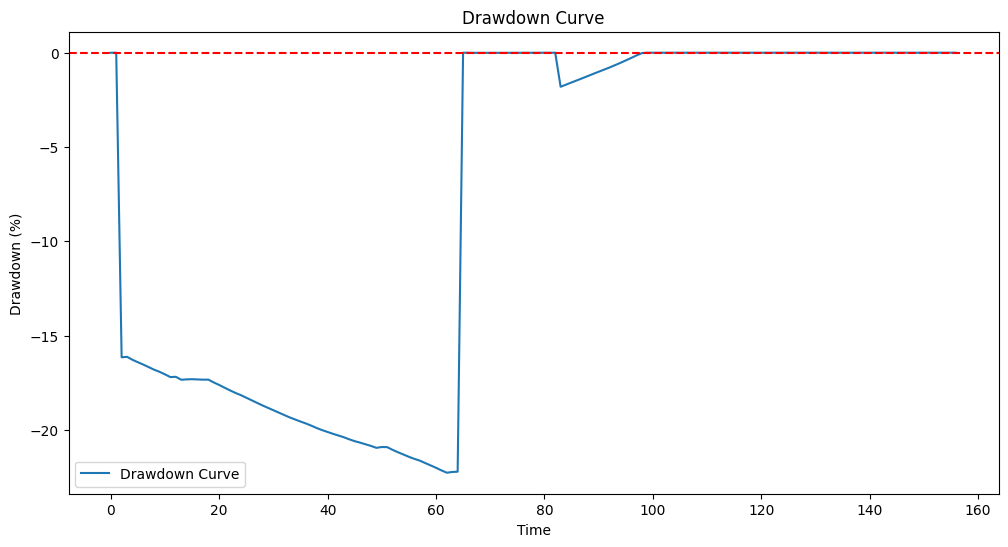

Sensitivity Analysis Parameters:
Entry Threshold: 1.0
Exit Threshold: 0.0


Entry signal z_score : -1.0052135525841734 // entry_threshold : 1.0 // direction : 1
10000
{}
{'HE.n.0': {'direction': 'LONG', 'units': 25.588133414555365, 'entry_price': 69.9, 'weight': 0.89430526283871}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.3501364204609211, 'entry_price': 495.75, 'weight': -0.10569473716128996}}
8384.96960476608
Entry signal z_score : -1.0547913337096118 // entry_threshold : 1.0 // direction : 1
8384.96960476608
{'HE.n.0': {'direction': 'LONG', 'units': 25.588133414555365, 'entry_price': 69.9, 'weight': 0.89430526283871}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.3501364204609211, 'entry_price': 495.75, 'weight': -0.10569473716128996}}
{'HE.n.0': {'direction': 'LONG', 'units': 47.26074164081237, 'entry_price': 69.57899729814483, 'weight': 0.89430526283871}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.7059326356237425, 'entry_price': 495.11998908038777, 'weight': -0.10569473716128

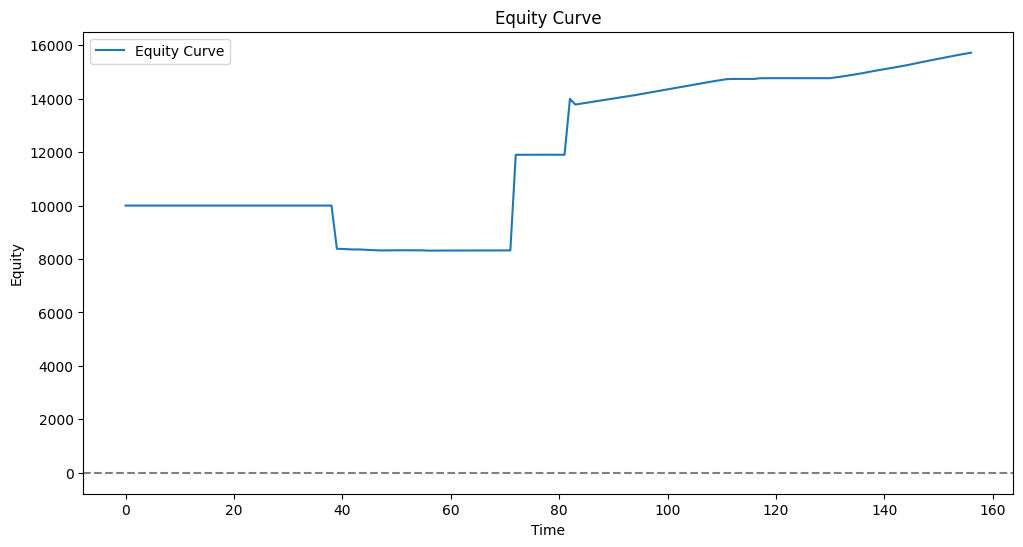

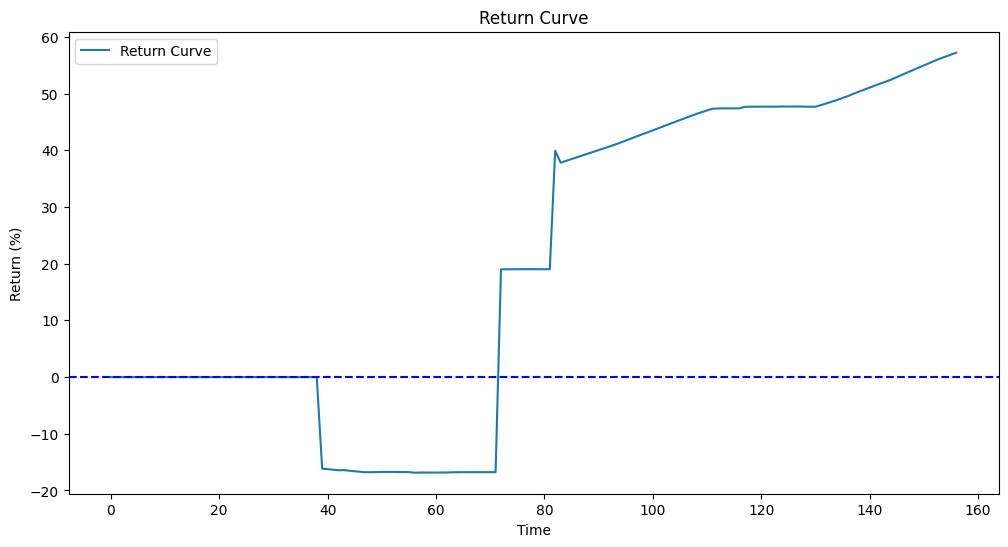

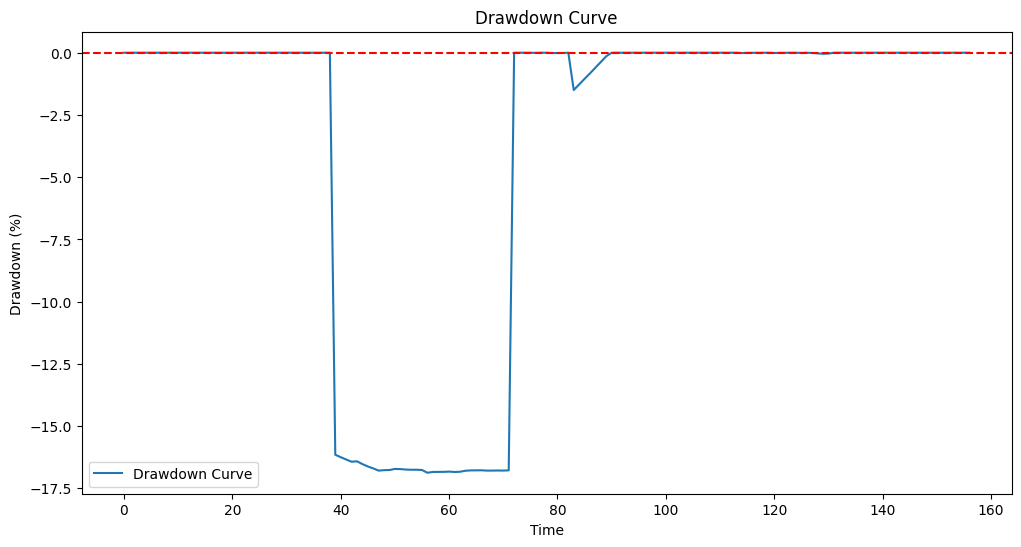

Entry Threshold, Exit Threshold | Total Return(%) | Sharpe Ratio | Max Drawdown(%)
0.5, 0.0 | 197.31% | -0.15 | -22.27%
1.0, 0.0 | 57.22% | -0.93 | -16.87%
Parameter Summary:
Segment: 3
Initial Capital: 10000
Training Data Range: 2018-05-18 00:00:00+00:00 to 2022-02-08 00:00:00+00:00
Testing Data Range: 2022-02-09 00:00:00+00:00 to 2023-01-17 00:00:00+00:00



Ideal Lag : 9

Number of cointerated realtionships : 1

  Hypothesis  Eigenvalue  Trace Statistic  Critical Value (Trace)  Max Eigenvalue Statistic  Critical Value (Max Eigenvalue) Decision (Trace) Decision (Max Eigenvalue)
0         H0    0.015086        14.858185                 10.4741                 14.045738                          12.3212           Reject                    Reject
1         H1    0.000879         0.812448                  2.9762                  0.812448                           4.1296   Fail to Reject            Fail to Reject
** IF Trace Statistic > Critical Value AND Max Eigenvalue > Critical Value th

/Users/anthony/git-projects/midas/core/strategies/research/timeseries_analysis.py:722: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = model.params[-1]  # Get the AR coefficient (last parameter)



Half-Life : 236.192062707652


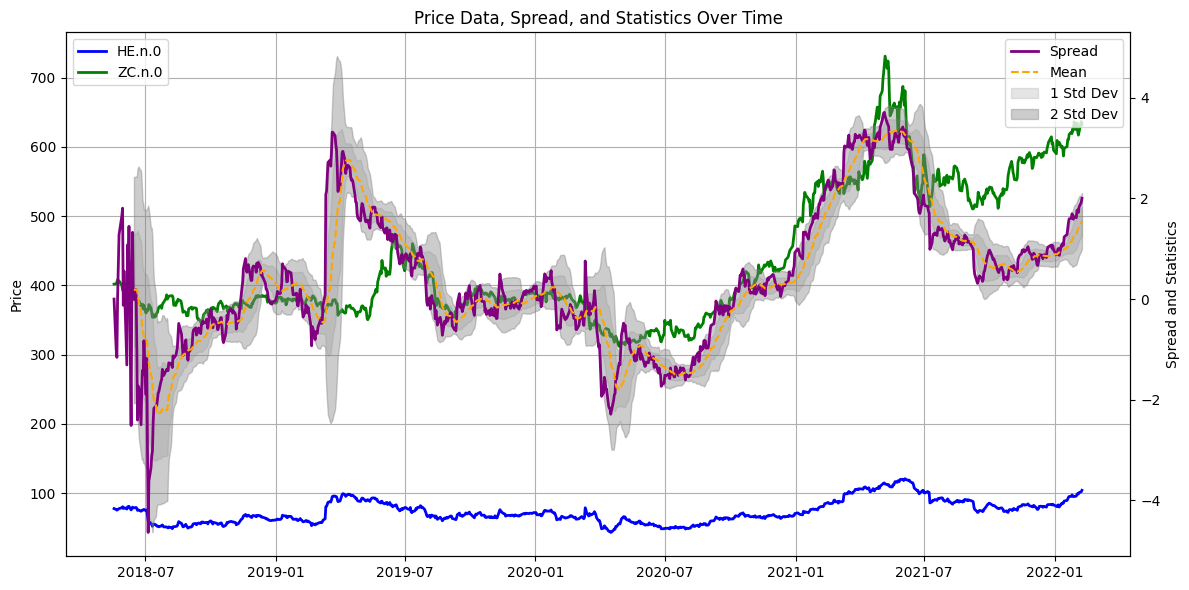

Sensitivity Analysis Parameters:
Entry Threshold: 0.5
Exit Threshold: 0.0


Entry signal z_score : 2.096385183602311 // entry_threshold : 0.5 // direction : -1
10000
{}
{'HE.n.0': {'direction': 'SHORT', 'units': -17.83488951712759, 'entry_price': 105.325, 'weight': -0.9392298691957317}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.22374445627440046, 'entry_price': 645.25, 'weight': -0.06077013080426835}}
12022.83084880252
Entry signal z_score : 1.9950189274173367 // entry_threshold : 0.5 // direction : -1
12022.83084880252
{'HE.n.0': {'direction': 'SHORT', 'units': -17.83488951712759, 'entry_price': 105.325, 'weight': -0.9392298691957317}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.22374445627440046, 'entry_price': 645.25, 'weight': -0.06077013080426835}}
{'HE.n.0': {'direction': 'SHORT', 'units': -39.655569411781116, 'entry_price': 104.32078441569642, 'weight': -0.9392298691957317}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.45355303207688846, 'entry_price': 643.0965882089066, 'we

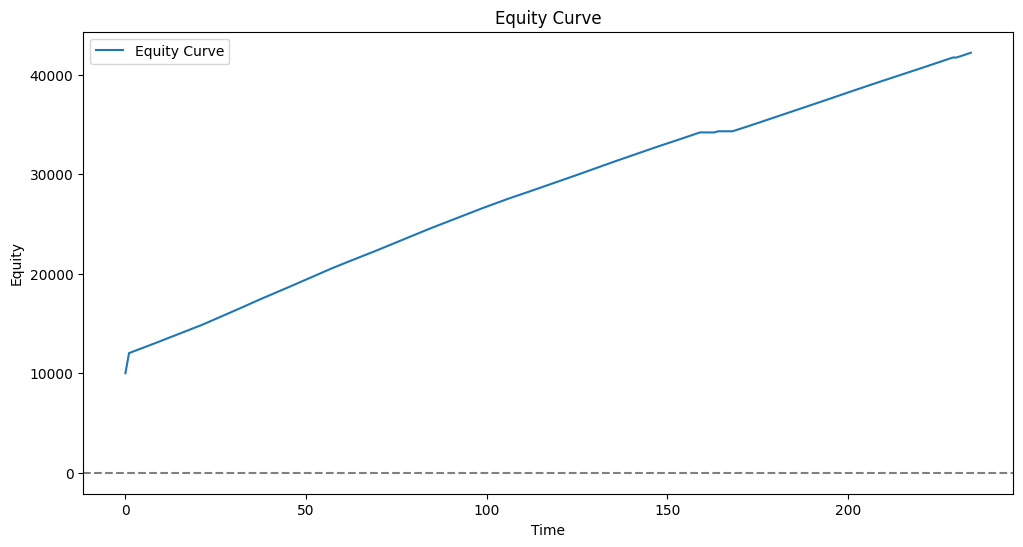

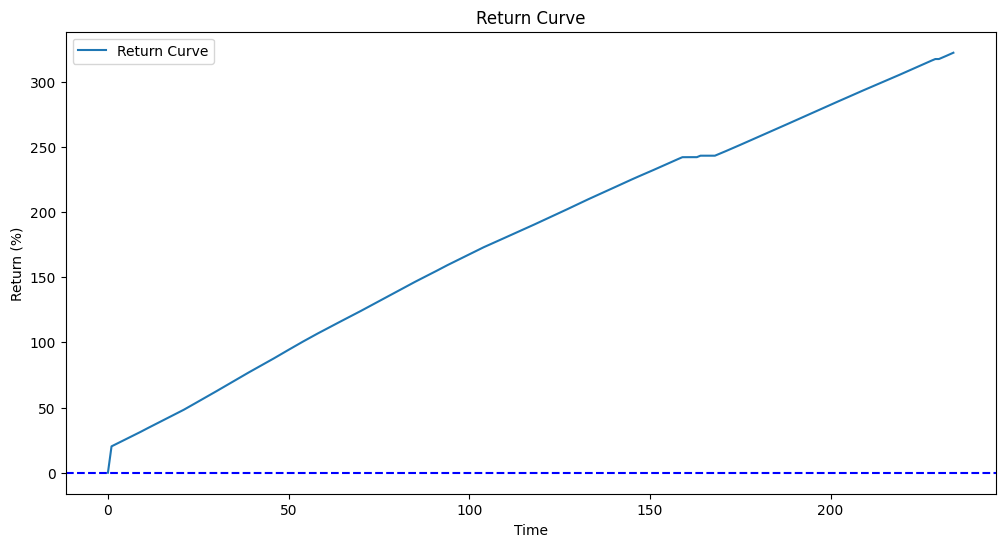

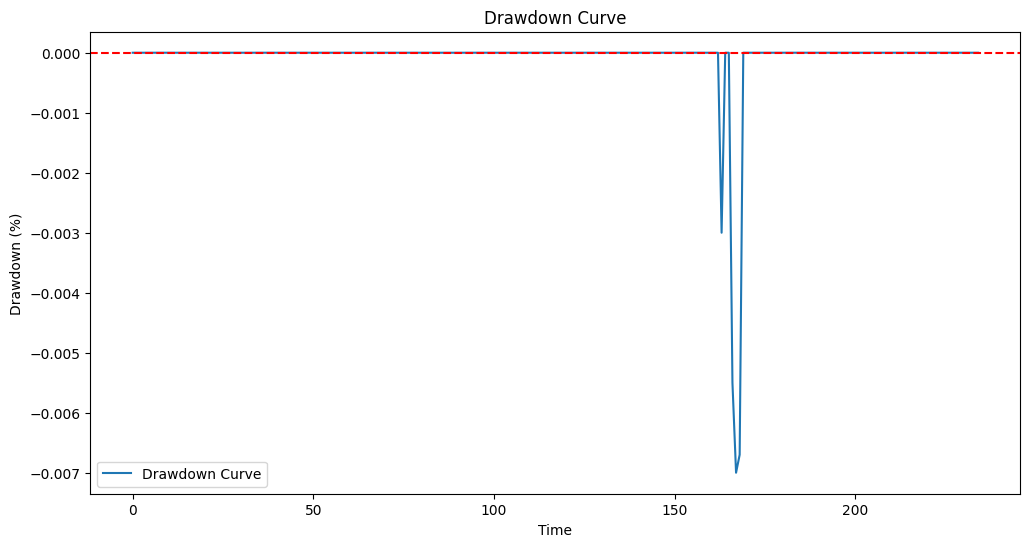

Sensitivity Analysis Parameters:
Entry Threshold: 1.0
Exit Threshold: 0.0


Entry signal z_score : 1.4176830712828188 // entry_threshold : 1.0 // direction : -1
10000
{}
{'HE.n.0': {'direction': 'SHORT', 'units': -17.83488951712759, 'entry_price': 105.325, 'weight': -0.9392298691957317}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.22374445627440046, 'entry_price': 645.25, 'weight': -0.06077013080426835}}
12022.83084880252
Entry signal z_score : 1.336823459458106 // entry_threshold : 1.0 // direction : -1
12022.83084880252
{'HE.n.0': {'direction': 'SHORT', 'units': -17.83488951712759, 'entry_price': 105.325, 'weight': -0.9392298691957317}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.22374445627440046, 'entry_price': 645.25, 'weight': -0.06077013080426835}}
{'HE.n.0': {'direction': 'SHORT', 'units': -39.655569411781116, 'entry_price': 104.32078441569642, 'weight': -0.9392298691957317}, 'ZC.n.0': {'direction': 'SHORT', 'units': -0.45355303207688846, 'entry_price': 643.0965882089066, 'we

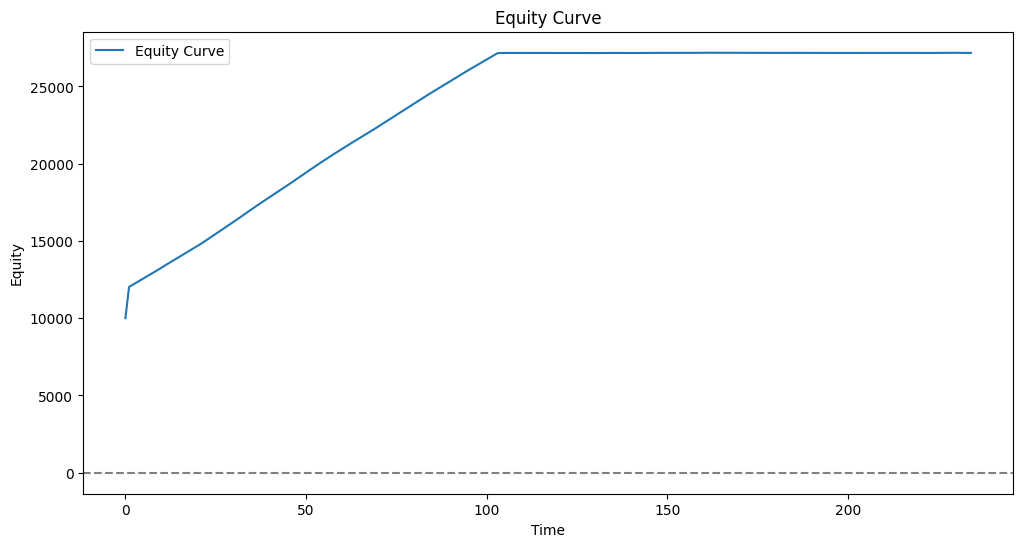

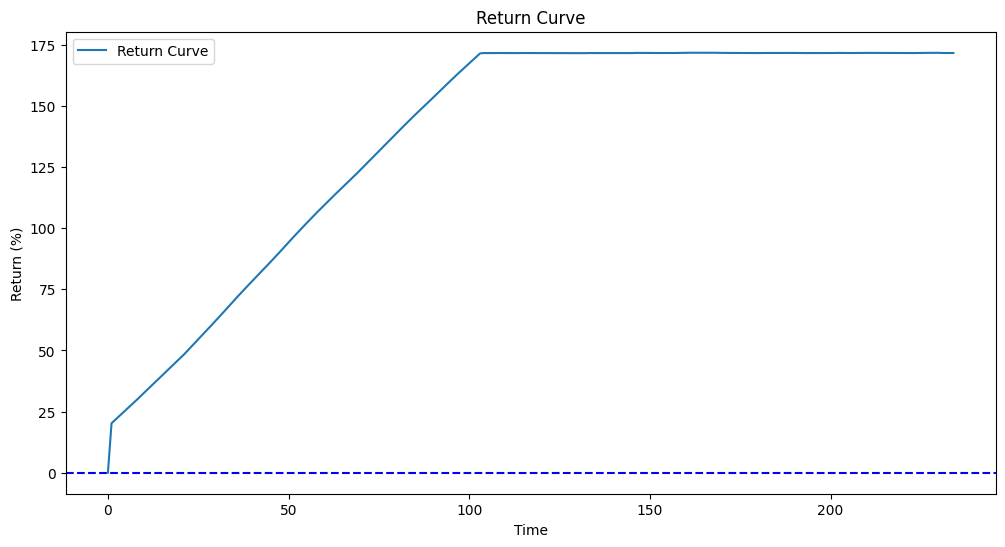

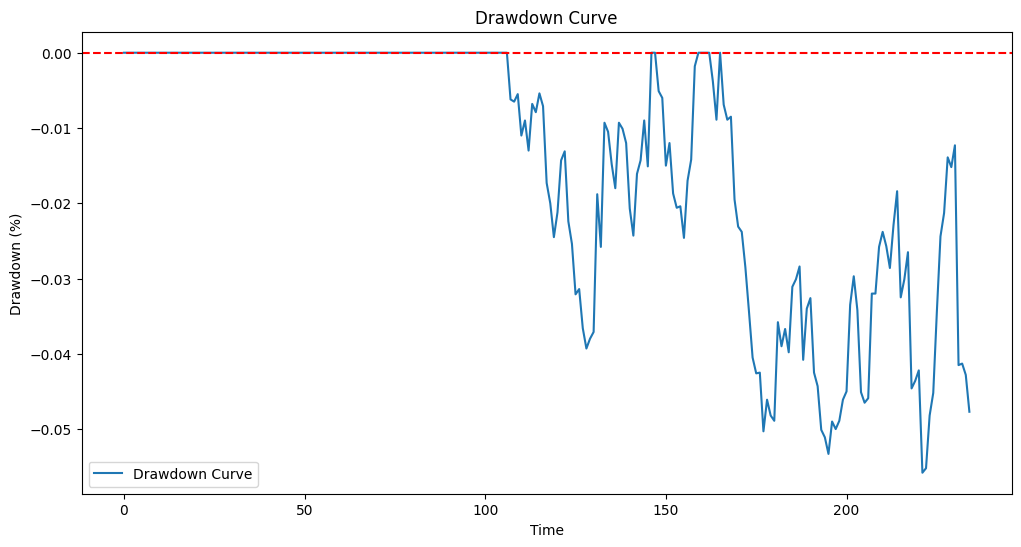

Entry Threshold, Exit Threshold | Total Return(%) | Sharpe Ratio | Max Drawdown(%)
0.5, 0.0 | 322.08% | -2.58 | -0.01%
1.0, 0.0 | 171.66% | -2.62 | -0.06%


In [60]:
# Strategy
strategy = CointegrationStrategy()
# Backtest
backtest = Backtest(strategy,full_data=data, trade_allocation=0.20)

# Parameters to be sensitized 
entry_thresholds = np.arange(0.5, 1.5, 0.5)  # Example range for entry
exit_thresholds = np.arange(0.5, 2.5, 0.5)  # Example range for exit

# Walk forward-analysis
backtest.walk_forward_analysis(total_segments=3, entry_thresholds=entry_thresholds, exit_thresholds=[0.0])


In [ ]:
# jupyter nbconvert --to pdf 'core/strategies/commodity_cointegration/research.ipynb'

